In [4]:
import numpy as np
import ctypes
from ctypes import *
import matplotlib.pyplot as plt
import time
from scipy import signal, optimize


"""Choose the dll file to test.cuda_min_jerk_float.dll contains function that runs all in float. cuda_min_jerk_double has time increment in double  """
# dll = WinDLL(r".\cuda_min_jerk_float.dll")
dll = WinDLL(r".\cuda_min_jerk_double.dll")

nVec = 20
#
sampleRate = 400
waveTime = 2500
size = int(sampleRate*waveTime)
#
window_time=10
# minimum jerk trajectory


"""minimum jerk trajectory generator: generate a unit trajectory going from 0 to 1 given a length in time. It returns the trajectory and the integral of the trajectory"""
def min_jerk_function(t,initial_position,final_position,numPoints):
    flat=0
    numPoints=numPoints-flat*2
    time=np.arange(0,t,t/numPoints)
    A=np.array([[0,0,0,0,0,1],[t**5,t**4,t**3,t**2,t**1,1],[0,0,0,0,1,0],[5*t**4,4*t**3,3*t**2,2*t,1,0],[0,0,0,2,0,0],[20*t**3,12*t**2,6*t,2,0,0]])
    b=np.array([initial_position,final_position,0,0,0,0])
    coef=np.dot(np.linalg.inv(A),b)
    time_array=np.array([time**5,time**4,time**3,0,0,0])
    time_array_int=np.array([time**6/6,time**5/5,time**4/4,0,0,0])

    jerk_ramp=np.dot(coef,time_array)
    jerk_int=np.dot(coef,time_array_int)
    jerk_ramp=np.hstack((np.zeros(flat),jerk_ramp))
    jerk_ramp = np.hstack((jerk_ramp,np.ones(flat) ))
    jerk_ramp[-1]=1
    jerk_ramp = jerk_ramp.astype('float32')
    jerk_int = np.hstack((jerk_int,np.array(int(np.ceil(jerk_int[-1]))))).astype('float32')

    return jerk_ramp,jerk_int
rampFn,intRampFn=min_jerk_function(waveTime,0,1,waveTime*sampleRate)

"""benchmark"""

nVecList = np.arange(1,200,20)
tList = []


for i in nVecList:
    dll.cudaInitialize()
    print(i)
    size = int(1000000) # Assume the single waveform has 1M points
    nVec = int(i)
#
# # waveform parameters
    amp = np.ones(nVec).astype('float32')*1
    freq = np.linspace(50,100,nVec).astype('float32')*2*np.pi
    phase = np.zeros(nVec).astype('float32')

    Damp = np.ones(nVec).astype('float32')*2
    Dfreq = np.ones(nVec).astype('float32')*2*np.pi*2
    Dphase = np.ones(nVec).astype('float32')

    arrayOut = np.zeros(size).astype('float32')

    # cast the array into Cpp data
    amp_p = amp.ctypes.data_as(POINTER(c_float))
    freq_p = freq.ctypes.data_as(POINTER(c_float))
    phase_p = phase.ctypes.data_as(POINTER(c_float))
    Damp_p = Damp.ctypes.data_as(POINTER(c_float))
    Dfreq_p = Dfreq.ctypes.data_as(POINTER(c_float))
    Dphase_p = Dphase.ctypes.data_as(POINTER(c_float))
    rampFn_p = rampFn.ctypes.data_as(POINTER(c_float))
    intRampFn_p = intRampFn.ctypes.data_as(POINTER(c_float))

    arrayOut_p = arrayOut.ctypes.data_as(POINTER(c_float))

    t0 = time.time()
    for j in range(100):
        # t0 = time.time()
        dll.cudaRearrange(intRampFn_p, rampFn_p, amp_p,Damp_p, freq_p, Dfreq_p, phase_p,Dphase_p, arrayOut_p, size, nVec)
        # print(time.time()-t0)
    tList.append((time.time() - t0)*1e3/100)





C:\Users\shuom\AppData\Local\Temp\ipykernel_16596\4073736824.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_array=np.array([time**5,time**4,time**3,0,0,0])
C:\Users\shuom\AppData\Local\Temp\ipykernel_16596\4073736824.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_array_int=np.array([time**6/6,time**5/5,time**4/4,0,0,0])


1
21
41
61
81
101
121
141
161
181


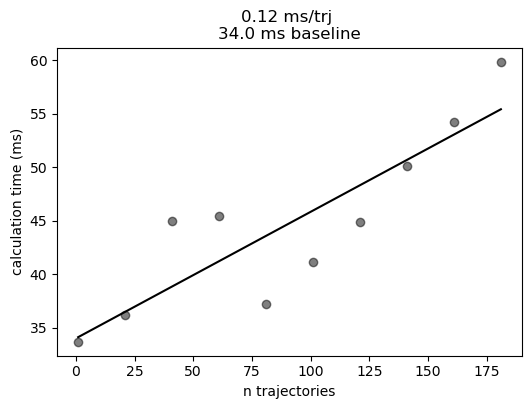

In [5]:
linear = lambda t,a,b: a*t+b
plt.figure(figsize=(6,4))
popt, _ = optimize.curve_fit(linear, nVecList, tList, bounds=((0,0),(np.inf, np.inf)))
plt.plot(nVecList,tList,'o',color='black',alpha=0.5)
plt.plot(nVecList, linear(nVecList,*popt),'-',color='black')
plt.title(str(np.round(popt[0],2))+ ' ms/trj \n' + str(np.round(popt[1],2)) + ' ms baseline')
plt.xlabel('n trajectories')
plt.ylabel('calculation time (ms)')
plt.show()


In [10]:
np.arrtList-1

[17.551088333129883,
 19.86837387084961,
 23.285691738128662,
 26.49113893508911,
 29.786441326141357,
 31.47001028060913,
 31.478488445281982,
 35.101706981658936,
 39.848408699035645,
 43.71652364730835]